In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import os 

import utils.sde_lib
import utils.models
from guans_network.Toy import ToyPolicy
import utils.losses as losses
from utils.datasets import get_dataset
import utils.samplers
from utils.misc import dotdict, batch_matrix_product
from utils.diff import batch_div_exact, hutch_div


In [2]:
opts =  dotdict({
    'dataset': 'spiral',
    'lr' : 3e-4,
    'num_iters' : 1000,
    'batch_size' : 512, 
    
})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = get_dataset(opts)
dim = dataset.dim

In [3]:
data = dataset.sample(512).to(device=device)
# aug_data = torch.cat((data, torch.zeros_like(data)),dim=-1)
time_pts = torch.linspace(0,1,100, device=device)
backward = True


itr=2000
model_path = f'./checkpoints/spiral_sb/itr_{itr}'

# model_path = f'./checkpoints/cld/itr_{itr}'
# model_backward = torch.load(os.path.join(model_path,f'backward_ema_{itr}.pt'))
# model_forward = torch.load(os.path.join(model_path,f'forward_ema_{itr}.pt'))

ckpts = torch.load('checkpoints/guans/stage_8.npz')
state_dict_backward = ckpts['z_b']
state_dict_forward = ckpts['z_f']
state_dict_backward = {k.replace('net.', ''): v for k, v in state_dict_backward.items()}
state_dict_forward = {k.replace('net.', ''): v for k, v in state_dict_forward.items()}

model_backward = ToyPolicy().to(device=device)
model_backward.load_state_dict(state_dict_backward)
model_backward.requires_grad_(False)
model_forward = ToyPolicy().to(device=device)
model_forward.load_state_dict(state_dict_forward)
model_forward.requires_grad_(False)

def forward_score(x,t):
    return model_forward(x,t)/5**.5
def backward_score(x,t):
    return model_backward(x,t)/5**.5

    
with torch.no_grad():
    sb = utils.sde_lib.SchrodingerBridge(backward_score=backward_score, forward_score=forward_score)
    in_cond = sb.prior_sampling(shape=(*data.shape,),device=data.device) if backward else data
    xt, trajectory, frozen_policy = sb.get_trajectories_for_loss(in_cond, time_pts,forward=not backward)
print(xt.shape)
print(trajectory.shape)
print(frozen_policy.shape)

torch.Size([512, 2])
torch.Size([512, 100, 2])
torch.Size([512, 100, 2])


tensor(379.5064, device='cuda:0', grad_fn=<AddBackward0>)


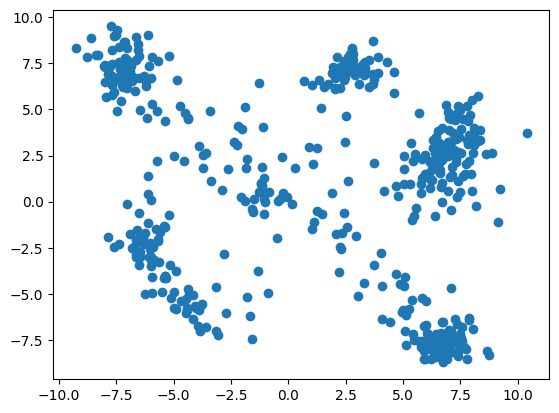

In [4]:
print(losses.standard_sb_loss(sb,data))
plt.scatter(xt[:,0].detach().cpu(),xt[:,1].detach().cpu())
plt.show()

In [5]:
bs, d = in_cond.shape
flat_traj = trajectory.reshape(-1,d).requires_grad_(True)
time_pts_shaped = time_pts.repeat(bs)
bt = sb.beta(time_pts_shaped)

if backward:
    opt_policy =  bt**.5 * sb.forward_score(flat_traj,time_pts_shaped) 
else:
    opt_policy =  bt**.5 * sb.backward_score(flat_traj,time_pts_shaped)
    
div_term = bt**.5 * batch_div_exact(opt_policy,flat_traj,time_pts_shaped)

log_likelihood = (opt_policy + frozen_policy.view(-1,d))

print(torch.sum(log_likelihood**2)/bs)
print(torch.sum(opt_policy * (.5 * opt_policy + frozen_policy.view(-1,d)))/bs)
print(torch.sum(div_term)/bs)

tensor(5365.9087, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1165.7983, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-193.4984, device='cuda:0', grad_fn=<DivBackward0>)


In [6]:
# data = dataset.sample(1000).to(device=device)
# aug_data = torch.cat((data, torch.zeros_like(data)),dim=-1)

# # noise, trajectory = cld.sample((1000,4),device,False, in_cond=aug_data)
# rand = torch.randn_like(xt)
# for i in range(trajectory.shape[1]):
#     plt.close()
#     plt.xlim(-4,4)
#     plt.ylim(-35,35)
#     plt.scatter(rand[:,0].cpu(),rand[:,1].cpu(),label='normal')
#     plt.scatter(aug_data[:,0].cpu(),aug_data[:,1].cpu(),label='data')
#     plt.scatter(trajectory[:,i,0].cpu(),trajectory[:,i,1].cpu(),label='dyn')
#     plt.legend()
#     plt.savefig(f'trajectory/{i}.png')